In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pykalman import KalmanFilter
import os

In [2]:
dir_in = 'D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSensors_allPPs'
os.chdir(dir_in)

raw_df = pd.read_csv('all_data_FINAL.csv')
print(raw_df.shape)
raw_df.head()

(1200, 48)


,pp_id,condition,ts(sec),frame,success,confidence,AU1_InnerBrowRaiser,AU2_OuterBrowRaiser,AU4_BrowLowerer,AU5_UpperLipRaiser,...,move_dist,move_duration,move_speed,scroll_dur,keyPress,press_dur,backsp,backsp_dur,pause_dur,pause_rate
0,pp02,N,60.163,1800.0,1.0,0.979333,0.124822,0.181006,0.251717,0.095600,...,5.659960,0.031436,703.808619,NaN,27,0.366753,27,0.037037,2.830594,4.717656
1,pp02,N,120.360,3600.0,1.0,0.975500,0.100794,0.032833,0.130733,0.056844,...,15.594104,0.023057,1940.534010,NaN,105,0.263460,105,0.028000,0.564831,0.941385
2,pp02,N,180.556,5400.0,1.0,0.975056,0.181544,0.064789,0.276167,0.064428,...,19.806823,0.023113,2461.080076,NaN,105,0.261484,105,0.028778,0.495433,0.825721
3,pp02,N,240.753,7200.0,1.0,0.977056,0.174183,0.089906,0.139750,0.076000,...,5.370893,0.023799,664.848872,NaN,45,0.272449,45,0.099056,1.512937,2.521561
4,pp02,N,300.950,9000.0,1.0,0.975194,0.141389,0.032494,0.236983,0.069117,...,NaN,NaN,NaN,NaN,131,0.318532,131,0.055815,0.417129,0.695215


In [3]:
# raw_df.describe(include='all')
# raw_df.info()
raw_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pp_id                     1200 non-null   object 
 1   condition                 1200 non-null   object 
 2   ts(sec)                   1187 non-null   float64
 3   frame                     1187 non-null   float64
 4   success                   1187 non-null   float64
 5   confidence                1187 non-null   float64
 6   AU1_InnerBrowRaiser       1187 non-null   float64
 7   AU2_OuterBrowRaiser       1187 non-null   float64
 8   AU4_BrowLowerer           1187 non-null   float64
 9   AU5_UpperLipRaiser        1187 non-null   float64
 10  AU6_CheekRaiser           1187 non-null   float64
 11  AU7_LidTightener          1187 non-null   float64
 12  AU9_NoseWringler          1187 non-null   float64
 13  AU10_UpperLipRaiser       1187 non-null   float64
 14  AU12_Lip

pp_id                         0
condition                     0
ts(sec)                      13
frame                        13
success                      13
confidence                   13
AU1_InnerBrowRaiser          13
AU2_OuterBrowRaiser          13
AU4_BrowLowerer              13
AU5_UpperLipRaiser           13
AU6_CheekRaiser              13
AU7_LidTightener             13
AU9_NoseWringler             13
AU10_UpperLipRaiser          13
AU12_LipCornerPuller         13
AU14_Dimpler                 13
AU15_LipCornerDepressonr     13
AU17_ChinRaiser              13
AU20_LipStretcher            13
AU23_LipTightener            13
AU25_LipsPart                13
AU26_JawDrop                 13
AU45_BlinkInt                13
AUc45_BlinkRate              13
AUc28_LipSuck                13
headOrient_x                 13
headOrient_y                 13
headOrient_z                 13
gazeCenter                   13
gazeUp                       13
gazeDown                     13
gazeRigh

Text(0.5, 1.0, 'distribution of labels')

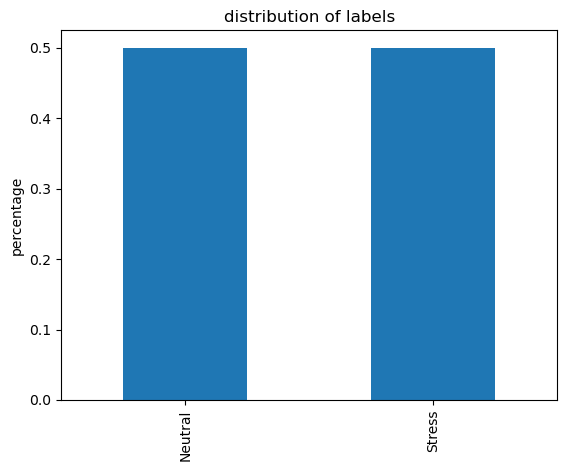

In [15]:
ax = (raw_df['condition'].value_counts()/raw_df.shape[0]).plot(kind='bar',  title = 'distribution of labels')
ax.set_xticklabels(['Neutral','Stress'])
plt.ylabel('percentage')
plt.title('distribution of labels')

In [4]:
auc_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer',
       'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener',
       'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
       'AU14_Dimpler', 'AU15_LipCornerDepressonr', 'AU17_ChinRaiser',
       'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart',
       'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck']
head_gaze_cols = ['headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp',
       'gazeDown', 'gazeRight', 'gazeLeft']
typing_cols = ['duration',
       'Rclick', 'Lclick', 'move_dist', 'move_duration', 'move_speed',
       'scroll_dur', 'keyPress', 'press_dur', 'backsp', 'backsp_dur',
       'pause_dur', 'pause_rate']
# num_cols = list(df.select_dtypes(include='float').columns)
num_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'duration', 'Rclick', 'Lclick', 'move_dist', 'move_duration', 'move_speed',
 'scroll_dur', 'keyPress', 'press_dur', 'backsp', 'backsp_dur', 'pause_dur', 'pause_rate']

stat_cols = ['AU1_InnerBrowRaiser', 'AU2_OuterBrowRaiser', 'AU4_BrowLowerer', 'AU5_UpperLipRaiser', 'AU6_CheekRaiser', 'AU7_LidTightener', 'AU9_NoseWringler', 'AU10_UpperLipRaiser', 'AU12_LipCornerPuller',
 'AU14_Dimpler','AU15_LipCornerDepressonr', 'AU17_ChinRaiser', 'AU20_LipStretcher', 'AU23_LipTightener', 'AU25_LipsPart', 'AU26_JawDrop', 'AU45_BlinkInt', 'AUc45_BlinkRate', 'AUc28_LipSuck',
 'headOrient_x', 'headOrient_y', 'headOrient_z', 'gazeCenter', 'gazeUp', 'gazeDown', 'gazeRight', 'gazeLeft', 'Rclick', 'Lclick', 'keyPress', 'move_dist','move_duration']



 COrrelation matrix and cluster map: 


d:\programs\anaconda-navigator\actuslprogrm\envs\ml4qs\lib\site-packages\seaborn\matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


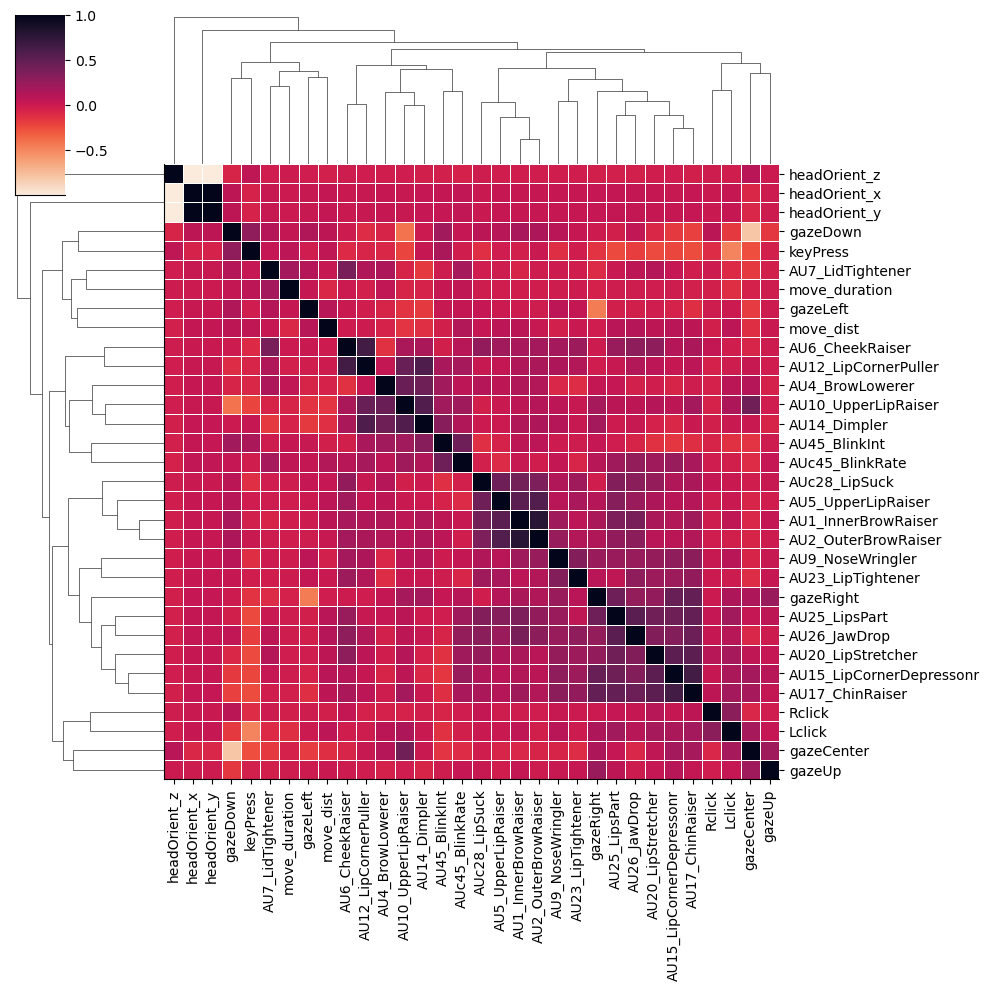

In [7]:
print('\n COrrelation matrix and cluster map: ')
# sns.clustermap(raw_df[num_cols].corr(), cmap="rocket_r", yticklabels=True, xticklabels=True)
sns.clustermap(raw_df[stat_cols].corr(), cmap="rocket_r", yticklabels=True, xticklabels=True, linewidths=0.5, center=0, square=True,  fmt=".2f")
sns.despine()

In [24]:
corr_pairs = pd.DataFrame(raw_df[num_cols].corr().unstack().sort_values(ascending= False).drop_duplicates())
print(corr_pairs)
# corr_pairs.to_csv('D:\\arxeia\\AI_VU\\THESIS_internship\\3-experimental\\data\\allSesonrs_allPPs_testingcorrelation_pairs.csv')


                                                0
pause_rate          pause_dur            1.000000
AU1_InnerBrowRaiser AU1_InnerBrowRaiser  1.000000
headOrient_y        headOrient_x         0.999999
move_speed          move_dist            0.948187
AU1_InnerBrowRaiser AU2_OuterBrowRaiser  0.786626
...                                           ...
backsp              Lclick              -0.490416
keyPress            press_dur           -0.640800
gazeCenter          gazeDown            -0.797199
headOrient_z        headOrient_y        -0.999999
                    headOrient_x        -1.000000

[742 rows x 1 columns]
